In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import matplotlib
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

# Data cleaning and Pre-processing 

In [2]:
#header creation and directory paths

usage_dir = "task_usage/"
job_dir = "job_events/"

task_usage_header = ['start_time','end_time','job_id','task_index','machine_id', 'mean_cpu_usage',
                     'canon_memory_usage', 'assign_memory_usage', 'unmapped_cache', 'total_cache', 
                     'max_mem', 'mean_io', 'mean_space', 'max_cpu', 'max_io', 'cpi', 'mai', 'sample',
                     'agg_type', 'sample_cpu_usage']

job_header = ['timestamp','missing_info', 'job_id', 'event_type', 'user_name', 'scheduling_class',
              'job_name','logical_job_name']

In [3]:
#read csv - drop unused columns

final_df = pd.DataFrame()

# 3 files used for each category
for i in range(10):
    file_str = str(i).zfill(5)
    usage_df = pd.read_csv(usage_dir +"part-"+file_str+"-of-00500.csv.gz",header=None)
    usage_df.columns = task_usage_header

    job_df = pd.read_csv(job_dir +"part-"+file_str+"-of-00500.csv.gz",header=None)
    job_df.columns = job_header

    job_df.drop(['missing_info','user_name', 'scheduling_class',
                  'job_name','logical_job_name'], axis =1,inplace=True)

    usage_df.drop(['task_index','machine_id','canon_memory_usage', 'assign_memory_usage', 'unmapped_cache', 'total_cache', 
                         'max_mem', 'mean_space', 'max_cpu', 'max_io', 'cpi', 'mai', 'sample',
                         'agg_type', 'sample_cpu_usage','mean_cpu_usage'], axis =1,inplace=True)

    #merge to filter jobs with valid life - SCHEDULE to FINISH

    new_jobdf = pd.merge(job_df[(job_df['event_type'] == 1)],job_df[ (job_df['event_type'] == 4)], on = "job_id")
    new_jobdf.drop(['event_type_x',  'event_type_y'], axis =1,inplace=True)
    new_jobdf['life_time'] = new_jobdf['timestamp_y'] -  new_jobdf['timestamp_x']
    new_jobdf.drop(['timestamp_x',  'timestamp_y'], axis =1,inplace=True)
    #new_jobdf
    
    
    #merge to get cpu usage of jobs with valid lifetime

    n_jobdf = pd.merge(usage_df,new_jobdf, on = "job_id")
    n_jobdf['start_time'] = (n_jobdf['start_time']/1000000)
    n_jobdf['end_time'] = (n_jobdf['end_time']/1000000)
    n_jobdf['life_time'] = (n_jobdf['life_time']/1000000)

    # arrange cpu uses by jobs- add parallel cpu uses of all tasks of a jobs during a time cycle
    
    final_df = final_df.append(n_jobdf.groupby(['job_id','start_time','end_time']).sum())
final_df
final_df.dropna(axis =0, inplace = True)


In [4]:
final_df.reset_index(level='start_time',inplace=True)
final_df.reset_index(level='end_time',inplace=True)

In [6]:
#job_ids = dummy.index.get_level_values(0).unique()
#print(len(job_ids))


In [7]:
final_df
final_df.groupby("job_id").count()

,end_time,start_time,mean_io,life_time
job_id,,,,
6245463804,12,12,12,12
6248941479,15,15,15,15
6248963537,15,15,15,15
6250895278,17,17,17,17
6250925784,4,4,4,4
6250927148,4,4,4,4
6251093705,9,9,9,9
6251093793,8,8,8,8
6251103434,8,8,8,8


# Data normalization and Binning

In [9]:
#normalising the mean cpu usage - y axis
# print(final_df.index.get_level_values(0).unique())
# for i in final_df.index.get_level_values(0).unique():


for i in final_df.index.get_level_values(0).unique():
    minn = final_df.loc[i]['mean_io'].min()
    maxx = final_df.loc[i]['mean_io'].max() 
    # print(minn,maxx)
    small_df = final_df[final_df.index == i]
    small_df['mean_io'] = (small_df['mean_io'] - minn)/(maxx-minn)
    final_df[final_df.index == i] = small_df
final_df

/Users/banani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,end_time,start_time,mean_io,life_time
job_id,,,,
6245463804,900.0,600.0,0.001703,3452.681356
6245463804,1200.0,900.0,0.001703,3452.681356
6245463804,1500.0,1200.0,0.001703,3452.681356
6245463804,1800.0,1500.0,0.005961,3452.681356
6245463804,2100.0,1800.0,0.001703,3452.681356
6245463804,2400.0,2100.0,0.001703,3452.681356
6245463804,2700.0,2400.0,0.003406,3452.681356
6245463804,3000.0,2700.0,0.001703,3452.681356
6245463804,3300.0,3000.0,1.000000,3452.681356


# Sample Distribution Plots

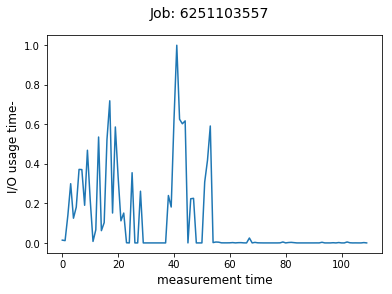

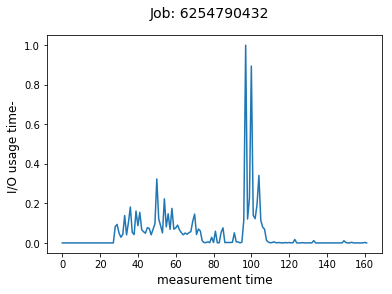

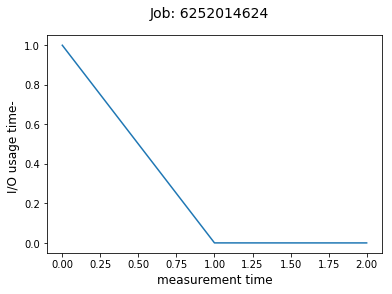

In [10]:
#5 plots of random jobs and their cpu usages

small_df = final_df[final_df.index == 6251103557]
colVals = small_df['mean_io'].tolist()
fig = plt.figure()
plt.plot(colVals)
fig.suptitle('Job: 6251103557', fontsize=14)
plt.xlabel('measurement time', fontsize=12)
plt.ylabel('I/O usage time- ', fontsize=12)
plt.show()

# small_df = final_df[final_df.index == 6248941479]
# colVals = small_df['mean_io'].tolist()
# plt.plot(colVals)
# plt.show()

small_df = final_df[final_df.index == 6254790432]
colVals = small_df['mean_io'].tolist()
fig = plt.figure()
plt.plot(colVals)
fig.suptitle('Job: 6254790432', fontsize=14)
plt.xlabel('measurement time', fontsize=12)
plt.ylabel('I/O usage time- ', fontsize=12)
plt.show()


# small_df = final_df[final_df.index == 6252015953]
# colVals = small_df['mean_io'].tolist()
# plt.plot(colVals)
# plt.show()

small_df = final_df[final_df.index == 6252014624]
colVals = small_df['mean_io'].tolist()
fig = plt.figure()
plt.plot(colVals)
fig.suptitle('Job: 6252014624', fontsize=14)
plt.xlabel('measurement time', fontsize=12)
plt.ylabel('I/O usage time- ', fontsize=12)
plt.show()

# small_df = final_df[final_df.index == 6252014624]
# colVals = small_df['mean_io'].tolist()
# plt.plot(colVals)
# plt.show()

# small_df = final_df[final_df.index == 6252018909]
# colVals = small_df['mean_io'].tolist()
# plt.plot(colVals)
# plt.show()

# small_df = final_df[final_df.index == 6245463804]
# colVals = small_df['mean_io'].tolist()
# plt.plot(colVals)
# plt.show()


In [11]:
#function to calculate values in each bin of each job's cpu uasge distribution

def calc_point(x1,y1,x2,y2,point):
    y=(point-x1)*(y2-y1)/(x2-x1)+y1
    if math.isnan(y):
        return -1000
    return y
def calculateValues(dataframe):
    my_points=[]
    start_index = 0
    next_index=1
    row0 = dataframe.iloc[start_index]
    row1 = dataframe.iloc[next_index]
    point = row0.end_time
    x1= row0.end_time
    x2= row1.end_time
    y1= row0.mean_io
    y2= row1.mean_io
    end_point = dataframe.iloc[dataframe.shape[0]-1].end_time
    my_points.append(y1)
#     print(point)
#     print(end_point)
    bin_size = (end_point-point)/100
#     print(bin_size)
    for i in range(100):
        point = point + bin_size
        if point > x2:
            start_index += 1
            next_index += 1
            if next_index >= dataframe.shape[0]:
                return my_points
            row0 = dataframe.iloc[start_index]
            row1 = dataframe.iloc[next_index]
            point = row0.end_time
            x1= row0.end_time
            x2= row1.end_time
            y1= row0.mean_io
            y2= row1.mean_io
#         print(point)
        val = calc_point(x1,y1,x2,y2,point)
        if val == -1000:
            return [-1000]
        my_points.append(val)
#     print(len(my_points))
    my_points.append(0)
    return my_points

In [12]:
#divide each lifetime into 100 bins
#get vector of all job's common usage distribution

# dummy = final_df.reset_index(level='start_time')
# dummy.reset_index(level='end_time',inplace=True)

dummy = final_df

job_ids = dummy.index.get_level_values(0).unique()
count = len(job_ids)
# job_ids
prev_point = [0]*102
for job_id in job_ids:
    #print(job_id)
    small_df = dummy[dummy.index == job_id]
    if small_df.shape[0] > 10:
        ponts = calculateValues(small_df)
#         print(ponts)
        if ponts[0] != -1000:
            prev_point = [x + y for x, y in zip(prev_point, ponts)]
#         print(len(prev_point))
#     print(small_df)
#final_df.index.unique().shape[0]
newList = [x / count for x in prev_point]

/Users/banani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


# Hypothesis testing- KS Test

In [13]:
#vector of mean of all the distribution - 100 values
newList

[0.0025346864889874954,
 0.005597864633329651,
 0.0071854038955811664,
 0.008110851654990188,
 0.00850470201158105,
 0.008672697819424438,
 0.00880264578091267,
 0.008808331593665078,
 0.008349563645966831,
 0.007801916748160214,
 0.007326560088150089,
 0.006999001607700105,
 0.006708034790292284,
 0.006222024112510949,
 0.005686621963199815,
 0.005371545168885423,
 0.005076525094933024,
 0.004738351689568024,
 0.004315022707689631,
 0.003761938235110672,
 0.0034207897215882167,
 0.003109791457318706,
 0.0026632793164536508,
 0.0024004232141558147,
 0.002137598180041193,
 0.0019612711497473977,
 0.001811922178500277,
 0.0016658686491377772,
 0.0015109605989636218,
 0.001375273763653817,
 0.0012668849050334991,
 0.0012160621945283387,
 0.001216032464982425,
 0.0012421825293150923,
 0.0014276668124713152,
 0.0012520043567847941,
 0.0011034813803268908,
 0.0011907742066127568,
 0.0012004261144964105,
 0.001218054048655921,
 0.0012304618716927678,
 0.001250059646906364,
 0.0012767630913077

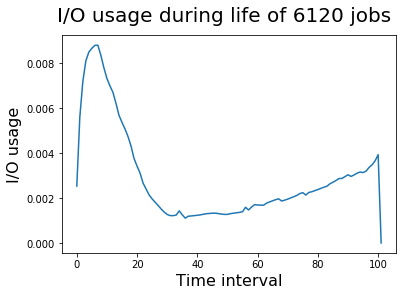

In [14]:
#plot graph of mean usage distribution

fig = plt.figure()
plt.plot(newList)
fig.suptitle('I/O usage during life of 6120 jobs', fontsize=20)
plt.xlabel('Time interval', fontsize=16)
plt.ylabel('I/O usage', fontsize=16)



plt.show()

In [15]:
#K_S test to see if this vector comes from a normal distribution

#print(newList)
val =stats.kstest(newList, 'norm')
val

KstestResult(statistic=0.5, pvalue=0.0)

# CPU Usage vs Memory Usage

In [16]:
vec = [
 0.00288779702122919,
 0.005596395511027189,
 0.007109756362602586,
 0.007904303157385086,
 0.008370133783137676,
 0.008715513494472145,
 0.00901815706142132,
 0.009267601921668709,
 0.00928129130841654,
 0.009167148410525027,
 0.00914782965371047,
 0.009122542837955215,
 0.009033477116970978,
 0.008989937470547497,
 0.008891818338595127,
 0.008889171762098443,
 0.008719921223039297,
 0.008660839268592065,
 0.008550833875437903,
 0.008400017068185864,
 0.008316051802016193,
 0.008302328221040411,
 0.008315158061115737,
 0.008236233595626327,
 0.007979302945706025,
 0.007951940700033282,
 0.007961888285562706,
 0.007972221957271439,
 0.007799357489286218,
 0.007834725140633313,
 0.007819445292123143,
 0.007852894506514689,
 0.007896859510335658,
 0.007963216256408412,
 0.008038608207603019,
 0.007973301974670353,
 0.007939072597725848,
 0.007925164283389616,
 0.007950258789998879,
 0.007966488168376987,
 0.007868527257779987,
 0.007823584272416981,
 0.007846192963154234,
 0.007846349400621974,
 0.007832358982908587,
 0.007867479139790082,
 0.00796056358126962,
 0.007914507910964229,
 0.007871067081395285,
 0.007914191221895015,
 0.007884779005661674,
 0.007851723432361913,
 0.007904074469508315,
 0.007946207490257201,
 0.007970052729375345,
 0.008017096429996286,
 0.00795587981417692,
 0.007983882672092584,
 0.007905701704291116,
 0.007959766428421567,
 0.008003510785873922,
 0.008069251482859084,
 0.008150859004442311,
 0.0082724202788066,
 0.008365969033577815,
 0.008459632021466622,
 0.008519422098697051,
 0.008581874375203738,
 0.008550425036386013,
 0.008614677273235333,
 0.008683105942047497,
 0.008748728559754428,
 0.008812439516976444,
 0.008872683294884347,
 0.008966934662131415,
 0.009062093894620874,
 0.009076729263820329,
 0.009207200693039434,
 0.009291914541894401,
 0.009388217225153506,
 0.009470003461903635,
 0.00964491278937629,
 0.009615354122977215,
 0.009569882194730305,
 0.009671819293097846,
 0.009750671650865177,
 0.009747327694599734,
 0.009825425115497126,
 0.00977082006940664,
 0.009835520214930208,
 0.009890720427888928,
 0.00984354615170759,
 0.009914147666411575,
 0.009978303772136701,
 0.010029168062451525,
 0.009947077405642775,
 0.009940581110775159,
 0.010048835144291439,
 0.010055308438924817,
 0.010045559230426309,
 0.01002859527035294,
 0.0]

In [17]:
vec

[0.00288779702122919,
 0.005596395511027189,
 0.007109756362602586,
 0.007904303157385086,
 0.008370133783137676,
 0.008715513494472145,
 0.00901815706142132,
 0.009267601921668709,
 0.00928129130841654,
 0.009167148410525027,
 0.00914782965371047,
 0.009122542837955215,
 0.009033477116970978,
 0.008989937470547497,
 0.008891818338595127,
 0.008889171762098443,
 0.008719921223039297,
 0.008660839268592065,
 0.008550833875437903,
 0.008400017068185864,
 0.008316051802016193,
 0.008302328221040411,
 0.008315158061115737,
 0.008236233595626327,
 0.007979302945706025,
 0.007951940700033282,
 0.007961888285562706,
 0.007972221957271439,
 0.007799357489286218,
 0.007834725140633313,
 0.007819445292123143,
 0.007852894506514689,
 0.007896859510335658,
 0.007963216256408412,
 0.008038608207603019,
 0.007973301974670353,
 0.007939072597725848,
 0.007925164283389616,
 0.007950258789998879,
 0.007966488168376987,
 0.007868527257779987,
 0.007823584272416981,
 0.007846192963154234,
 0.007846349400

In [18]:
val =stats.ks_2samp(vec, newList)

In [19]:
val

Ks_2sampResult(statistic=0.8921568627450981, pvalue=4.92692760536236e-37)

In [20]:
jobids = final_df.index.get_level_values(0).unique()
print(len(jobids))
for j in jobids:
    small_df = final_df[final_df.index == j]
    if small_df.shape[0] < 100:
        final_df.drop(j, axis =0, inplace = True)
final_df

6120


,end_time,start_time,mean_io,life_time
job_id,,,,
6251103557,900.0,600.0,0.014076,62300.053680
6251103557,1200.0,900.0,0.011632,62300.053680
6251103557,1280.0,1200.0,0.140552,2076.668456
6251103557,1282.0,1200.0,0.299595,4153.336912
6251103557,1283.0,1200.0,0.125014,2076.668456
6251103557,1284.0,1200.0,0.180874,2076.668456
6251103557,1285.0,1200.0,0.371885,4153.336912
6251103557,1288.0,1200.0,0.371015,4153.336912
6251103557,1289.0,1200.0,0.190302,2076.668456


In [21]:
time_series_df = final_df

# TIME SERIES FOR MEAN IO USAGE IN A JOB'S LIFE CYCLE

In [22]:
time_series_df

,end_time,start_time,mean_io,life_time
job_id,,,,
6251103557,900.0,600.0,0.014076,62300.053680
6251103557,1200.0,900.0,0.011632,62300.053680
6251103557,1280.0,1200.0,0.140552,2076.668456
6251103557,1282.0,1200.0,0.299595,4153.336912
6251103557,1283.0,1200.0,0.125014,2076.668456
6251103557,1284.0,1200.0,0.180874,2076.668456
6251103557,1285.0,1200.0,0.371885,4153.336912
6251103557,1288.0,1200.0,0.371015,4153.336912
6251103557,1289.0,1200.0,0.190302,2076.668456


In [23]:
dataset_1 = pd.DataFrame()
dataset_2 = pd.DataFrame()
jobids = final_df.index.get_level_values(0).unique()
i=0
for j in jobids:
    small_df = final_df[final_df.index == j]
    if small_df.shape[0] >= 100 and small_df.shape[0] < 200:
        i=i+1
        if i==1:
            dataset_1=dataset_1.append(small_df)
        if i==2:
            dataset_2=dataset_2.append(small_df)
            print(j)
        if i>=3:
            break
dataset_1 = dataset_1[dataset_1['mean_io']!=0]
dataset_2 = dataset_2[dataset_2['mean_io']!=0]
# print(dataset_1)
# print(dataset_2)
        
        

6251463417


In [24]:
## helper functions

## in both the functions t is the current value

def EWMA(X, t, x_t_hat=None, alpha=0.5):
    if t == 0:    
        return alpha*X[t] * (1-alpha)*X[t]
    
    if x_t_hat:
        return alpha*X[t] + (1-alpha)*x_t_hat

    else:
        return alpha*X[t] + (1-alpha)*EWMA(X, t-1, None, alpha=alpha)
    
def errorCalc(actual,predict):
    print(actual[8],predict[8])
    return (np.abs(predict-actual)/actual).mean()
    

def seasonal_observed(X, t, season=144):
    return X[t-season+1]


class AutoRegression(object):
    def __init__(self, p=3, X=None):
        self.p = p
        self.X = X
        self.n = len(X)
        self.beta = np.ones((p, 1))/(p+1)
        self.LR_solver = LinearRegression(n_jobs=-1, fit_intercept=False)
        
    def get_features(self, start=0, end=-1):
        A = []
        
        for i in range(start, end-self.p):
            A.append(self.X[i:(i+self.p)])
    
        A = np.array(A)
        n = A.shape[0]
        A = np.hstack((np.ones((n,1)), A))
        return A
        
        
    def fit(self, end=-1): ## use 'end' inside, for our eg end = 577

        features = self.get_features(0, end)
        labels = np.array(self.X[self.p:end])
        self.LR_solver.fit(features, labels)
    
    def predict(self, t): ## t is the value we want to predict, same as the previous 'end' = 577
        features = self.get_features(t-self.p-1, t)
        return self.LR_solver.predict(features)
    
def plotGraph(X,pred_ewma,pred_auto,n):
#     print(X)
    fig = plt.figure()
    fig.suptitle('Job: 6254790432                   ', fontsize=20)
    plt.xlabel('Sample Index', fontsize=16)
    plt.ylabel('Sample Value', fontsize=16)
    plt.plot(np.arange(24, n), X, label='Actual_value', alpha=0.8)
    plt.plot(np.arange(24, n), pred_ewma, c='r', label='Predicted_EWMA', alpha=0.5)
    plt.plot(np.arange(24, n), pred_auto, c='g', label='Predicted_AR', alpha=0.6)
#     matplotlib.pyplot.legend()
    fig.legend(fontsize=14)
#    fig.legend(fontsize=14,loc='left')
    plt.show()

def calcTimeSeries(X):
    ar_model = AutoRegression(p=23, X=X)
    pred_auto = []
    n = len(X)
    for i in range(24, n):
        ar_model.fit(end=i)
        pred_auto.append(ar_model.predict(t=i))

    pred_auto = np.array(pred_auto).squeeze()
    
    y_t_hat = X[23]
    alpha = 0.5
    pred_ewma = []

    for i in range(24, n):
        y_t_hat = EWMA(X, i, y_t_hat, alpha)
        pred_ewma.append(y_t_hat)

    
    pred_ewma = np.array(pred_ewma)
#     print X[24]
#     print pred_auto
#     print pred_ewma
    y=[]
    for i in range(24,n):
        y.append(X[i])
    X=y
    plotGraph(X,pred_ewma,pred_auto,n)
    print ("EWMA error: ",errorCalc(np.array(X),np.array(pred_ewma)),"%")
    print ("AUTO REG error: ",errorCalc(np.array(X),np.array(pred_auto)),"%")

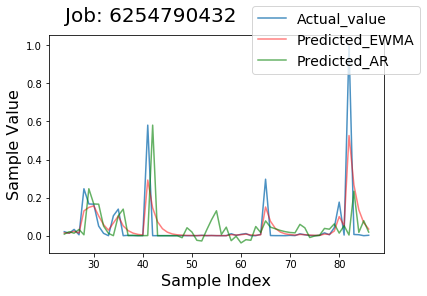

0.012407766990291261 0.058117638046116506
EWMA error:  39.38467494745867 %
0.012407766990291261 0.05063106796116647
AUTO REG error:  90.96832811631728 %


In [25]:
# calcTimeSeries(np.array(dataset_1['mean_io'].tolist()))
calcTimeSeries(np.array(dataset_2['mean_io'].tolist()))

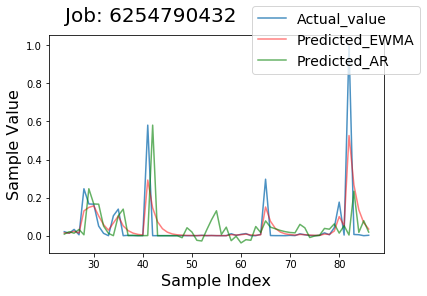

0.012407766990291261 0.058117638046116506
EWMA error:  39.38467494745867 %
0.012407766990291261 0.05063106796116647
AUTO REG error:  90.96832811631728 %


In [26]:
calcTimeSeries(np.array(dataset_2['mean_io'].tolist()))
